In [1]:
import os.path
import sqlite3
import socket
import matplotlib.pyplot as plt

from torch.utils.data import Dataset

if socket.gethostname() == 'LTSSL-sKTPpP5Xl':
    data_dir = 'C:\\Users\\ams90\\PycharmProjects\\ConceptsBirds\\data'
elif socket.gethostname() == 'LAPTOP-NA88OLS1':
    data_dir = 'D:\\data\\caltecBirds\\CUB_200_2011'
else:
    data_dir = '/home/bwc/ams90/datasets/caltecBirds/CUB_200_2011'


In [24]:
conn = sqlite3.connect(database=os.path.join(data_dir, 'birds.db'))
cursor = conn.cursor()

In [25]:
classes  = [(class_id, class_name)     for (class_id, class_name)     in cursor.execute("select class_id, class_name from classes").fetchall()]
concepts = [(concept_id, concept_name) for (concept_id, concept_name) in cursor.execute("select concept_id,concept_name from concepts").fetchall()]

In [26]:
def concept_value_counts():
    cursor = conn.cursor()
    sql = ("""select d.concept_name,
                     i.trainset,
                     a.value,
                     count(a.value)
              from   images i, 
                     classes cc, 
                     image_attributes ia,
                     attributes a,
                     concepts d
              where i.class_id = cc.class_id 
              and   i.image_id = ia.image_id 
              and   a.attribute_id = ia.attribute_id
              and   d.concept_id   = a.concept_id
              and   ia.present = 1
              and   cc.class_id = 3
              group by 
                     i.trainset,
                     cc.class_name,
                     d.concept_name,
                     a.value
              order by
                     d.concept_name,
                     cc.class_name,
                     i.trainset
                     """)
    cursor.execute(sql)
    records = cursor.fetchall()
    cursor.close()
    return records
records = concept_value_counts()

In [57]:
records

[('has_back_color', 0, 'black', 1),
 ('has_back_color', 0, 'brown', 2),
 ('has_back_color', 0, 'buff', 7),
 ('has_back_color', 0, 'grey', 11),
 ('has_back_color', 0, 'orange', 1),
 ('has_back_color', 0, 'white', 3),
 ('has_back_color', 1, 'black', 6),
 ('has_back_color', 1, 'blue', 1),
 ('has_back_color', 1, 'brown', 5),
 ('has_back_color', 1, 'buff', 1),
 ('has_back_color', 1, 'grey', 11),
 ('has_back_color', 1, 'purple', 1),
 ('has_back_color', 1, 'white', 7),
 ('has_back_pattern', 0, 'multi-colored', 5),
 ('has_back_pattern', 0, 'solid', 14),
 ('has_back_pattern', 0, 'striped', 2),
 ('has_back_pattern', 1, 'multi-colored', 5),
 ('has_back_pattern', 1, 'solid', 15),
 ('has_back_pattern', 1, 'spotted', 1),
 ('has_back_pattern', 1, 'striped', 3),
 ('has_belly_color', 0, 'black', 4),
 ('has_belly_color', 0, 'brown', 5),
 ('has_belly_color', 0, 'buff', 2),
 ('has_belly_color', 0, 'grey', 9),
 ('has_belly_color', 0, 'pink', 1),
 ('has_belly_color', 0, 'white', 3),
 ('has_belly_color', 1, 

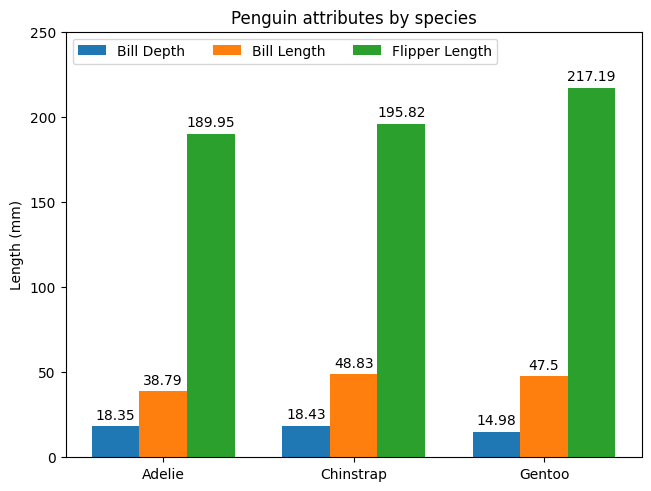

In [141]:
import numpy as np

species = ("Adelie", "Chinstrap", "Gentoo")
penguin_means = {
    'Bill Depth': (18.35, 18.43, 14.98),
    'Bill Length': (38.79, 48.83, 47.50),
    'Flipper Length': (189.95, 195.82, 217.19),
}

x = np.arange(len(species))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for attribute, measurement in penguin_means.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Length (mm)')
ax.set_title('Penguin attributes by species')
ax.set_xticks(x + width, species)
ax.legend(loc='upper left', ncols=3)
ax.set_ylim(0, 250)

plt.show()

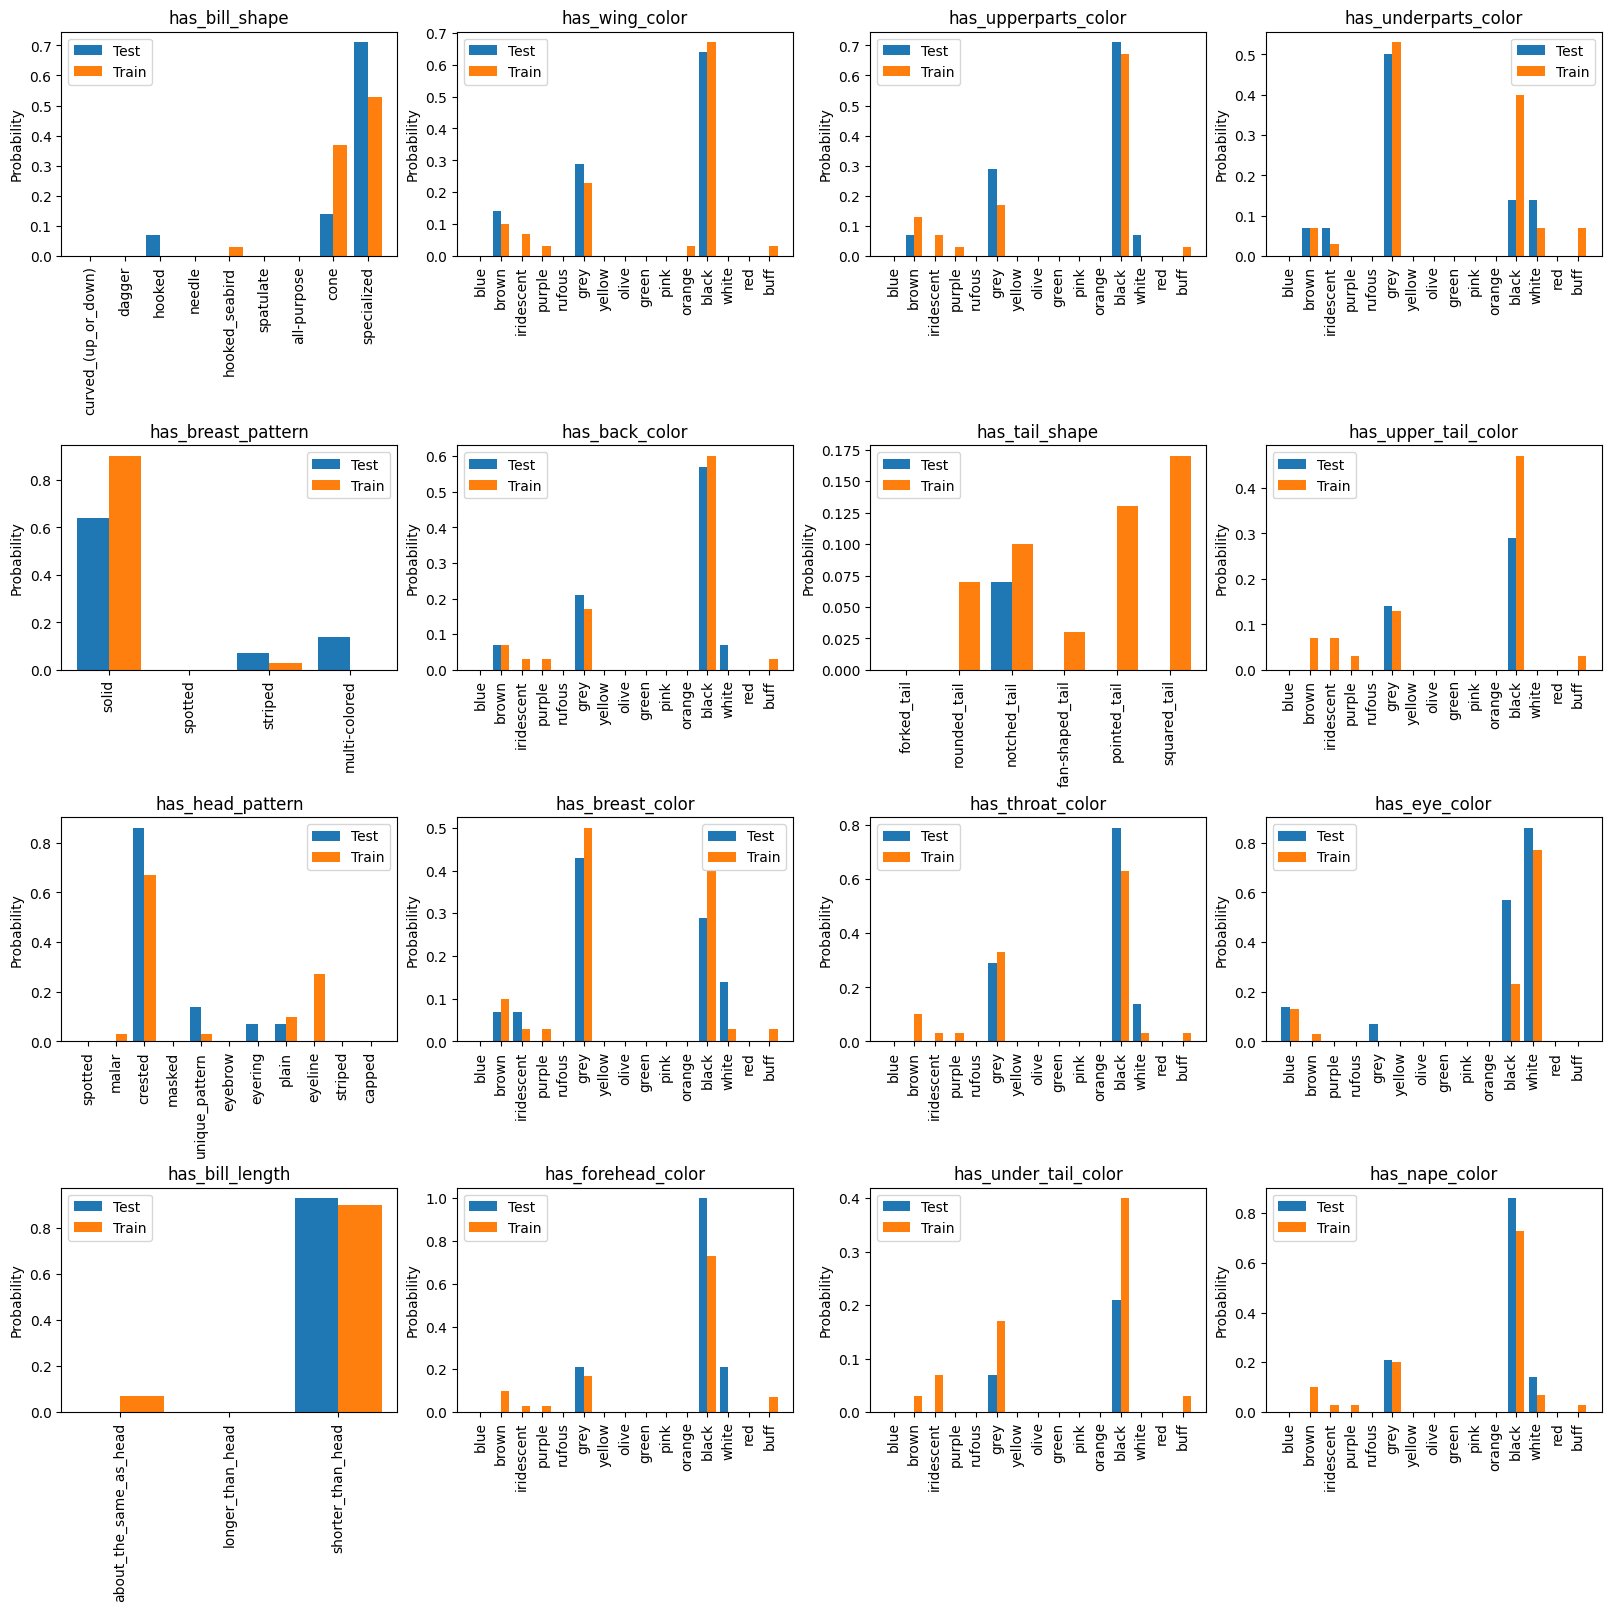

In [147]:
rows, cols = 4, 4
class_id = 5
fig, ax = plt.subplots(nrows=rows, ncols=cols, layout='constrained', figsize=(16,16))
for row in range(rows):
    for col in range(cols):
        concept_id = 1 + (row * cols)  + col
        # Retreive the list of possible values for the concept.
        values    = [value for value in cursor.execute("select value_id, value from attributes where concept_id = ?", (concept_id,)).fetchall()]
        value_ids   = [value[0] for value in values]
        value_names = [value[1] for value in values]
        
        # Retrieve the count of test/training examples of the class
        total_counts      = [counts[1] for counts in cursor.execute("select trainset, count(*) from images where class_id = ? group by trainset", (class_id,))]
        
        #Retrieve the counts of each value for the dataset/concept/value for images in class class_id and normalise        
        value_counts = [[cursor.execute("""select 
                                           count(*) 
                                           from  images i,
                                                 attributes a,
                                                 image_attributes ia
                                           where i.image_id = ia.image_id
                                           and   a.attribute_id = ia.attribute_id
                                           and   i.class_id     = ?
                                           and   i.trainset     = ?
                                           and   a.concept_id   = ?
                                           and   a.value_id     = ?
                                           and   ia.present     = 1
                                            """, (class_id, dataset, concept_id, value_id)).fetchone()[0]
                        for value_id in value_ids] for dataset in [0,1]]
        
        value_probabilities = [[round(val / total_counts[i], 2) for val in value_count] for i, value_count in enumerate(value_counts)]   
        
        
        width = 0.40  # the width of the bars
        multiplier = 0

        for dataset, probabilties in enumerate(value_probabilities):
            offset = width * multiplier
            bar_starts = [value_id + offset for value_id in value_ids]
            rects = ax[row][col].bar(bar_starts, probabilties, width)
            multiplier += 1
            
        tick_starts = [value_id + width/2 for value_id in value_ids]
    
               
        ax[row][col].set_title([concept[1] for concept in concepts if concept[0] == concept_id][0])
        ax[row][col].set_ylabel('Probability')
        ax[row][col].set_xticks(tick_starts, value_names, rotation=90)
        ax[row][col].legend( ['Test', 'Train'])
        


In [146]:
concepts

[(1, 'has_bill_shape'),
 (2, 'has_wing_color'),
 (3, 'has_upperparts_color'),
 (4, 'has_underparts_color'),
 (5, 'has_breast_pattern'),
 (6, 'has_back_color'),
 (7, 'has_tail_shape'),
 (8, 'has_upper_tail_color'),
 (9, 'has_head_pattern'),
 (10, 'has_breast_color'),
 (11, 'has_throat_color'),
 (12, 'has_eye_color'),
 (13, 'has_bill_length'),
 (14, 'has_forehead_color'),
 (15, 'has_under_tail_color'),
 (16, 'has_nape_color'),
 (17, 'has_belly_color'),
 (18, 'has_wing_shape'),
 (19, 'has_size'),
 (20, 'has_shape'),
 (21, 'has_back_pattern'),
 (22, 'has_tail_pattern'),
 (23, 'has_belly_pattern'),
 (24, 'has_primary_color'),
 (25, 'has_leg_color'),
 (26, 'has_bill_color'),
 (27, 'has_crown_color'),
 (28, 'has_wing_pattern')]